# FloPy Freyberg USG

This example demonstrates a MODFLOW USG Freyberg model, including construction of an `UnstructuredGrid` from a specification file and plotting head data in cross-section.

First we locate the model directory.

In [1]:
from pathlib import Path
import flopy

root_name = "freyberg.usg"
model_ws = Path.cwd().parent / "data" / root_name.replace('.', '_')

Now construct an `UnstructuredGrid` from a grid specification file.

In [2]:
from flopy.discretization import UnstructuredGrid

mfgrid = UnstructuredGrid.from_gridspec(str(model_ws / f"{root_name}.gsf"))

Plot the grid in map view.

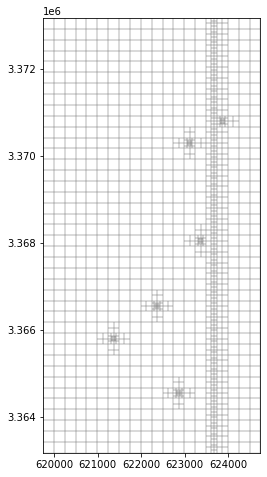

In [3]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, aspect="equal")
pmv = flopy.plot.PlotMapView(modelgrid=mfgrid, ax=ax)
pmv.plot_grid(alpha=0.1)

Create cross-section lines.

In [4]:
from flopy.utils.geometry import LineString

lines = [LineString(ls) for ls in
    [[(623000,3364000), (623000,3372000)],
    [(623650, 3364000), (623650, 3372000)]
]]

Load the model and retrieve inactive cells.

In [5]:
gwf = flopy.mfusg.MfUsg.load(f"{root_name}.nam",
                             model_ws=str(model_ws),
                             verbose=False,
                             check=False,
                             exe_name='mfusg')

bas6 = gwf.get_package('bas6')
ibound = bas6.ibound.array

Show the map view again with cross-section lines and inactive cells.

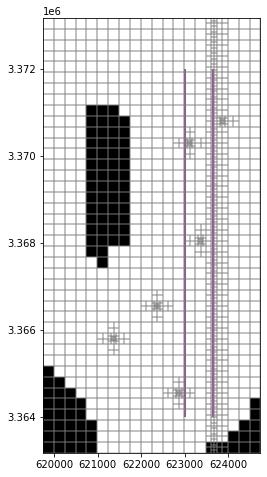

In [6]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, aspect="equal")
pmv = flopy.plot.PlotMapView(modelgrid=mfgrid, ax=ax)
grid = pmv.plot_grid(alpha=0.2)
shps = pmv.plot_shapes(lines, edgecolor='purple', lw=2, alpha=0.7)
inac = pmv.plot_inactive(ibound=ibound)

Next, we can run the model and plot cross-sections of the resulting head. We will run the model in a temporary workspace to avoid altering the example data.

In [7]:
from tempfile import TemporaryDirectory

# temporary directory
temp_dir = TemporaryDirectory()
work_dir = Path(temp_dir.name) / "freyberg_usg"

gwf.change_model_ws(str(work_dir))
gwf.write_name_file()
gwf.write_input()
gwf.run_model()


creating model workspace...
   ..\..\..\..\AppData\Local\Temp\7\tmptstlri8v\freyberg_usg
FloPy is using the following executable to run the model: ..\..\..\..\flopy\bin\mfusg.EXE

                                  MODFLOW-USG      
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUNDWATER FLOW MODEL
                             Version 1.5.00 02/27/2019                       

 Using NAME file: freyberg.usg.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2023/02/07 13:19:30

 Solving:  Stress period:     1    Time step:     1    Groundwater Flow Eqn.
 Solving:  Stress period:     2    Time step:     1    Groundwater Flow Eqn.
 Solving:  Stress period:     3    Time step:     1    Groundwater Flow Eqn.
 Solving:  Stress period:     4    Time step:     1    Groundwater Flow Eqn.
 Solving:  Stress period:     5    Time step:     1    Groundwater Flow Eqn.
 Solving:  Stress period:     6    Time step:     1    Groundwater Flow Eqn.
 Solving:  Stress period:     7    Time step:

(True, [])

Load head data from the output files:

In [8]:
import numpy as np

hds = flopy.utils.HeadUFile(str(work_dir / f"{root_name}.hds"), model=gwf)
times = hds.get_times()
head = np.array(hds.get_data())
print(head.shape)

(3, 1499)


Plot the head colormap and contours for each layer.

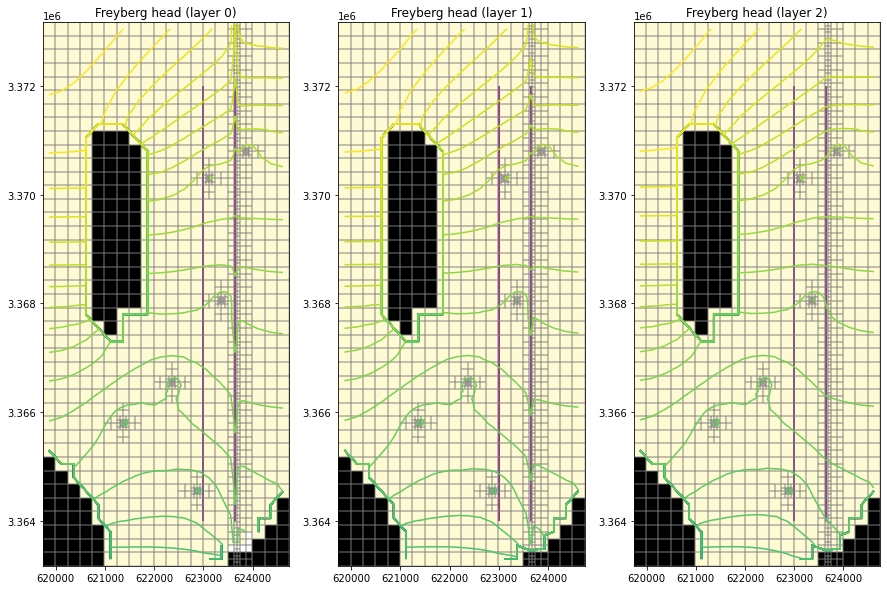

In [9]:
levels = np.arange(30, 35.4, 0.1)
fig = plt.figure(figsize=(15, 10))

for layer, h in enumerate(head):
    ax = fig.add_subplot(1, len(head), layer + 1)
    ax.set_title(f"Freyberg head (layer {layer})")
    pmv = flopy.plot.PlotMapView(modelgrid=mfgrid, ax=ax)
    mesh = pmv.plot_array(h, alpha=0.2)
    grid = pmv.plot_grid(alpha=0.2)
    shps = pmv.plot_shapes(lines, edgecolor='purple', lw=2, alpha=0.8)
    inac = pmv.plot_inactive(ibound=ibound)
    ctrs = pmv.contour_array(h, levels=levels)

A `head` argument can be provided to `CrossSectionPlot.contour_array()` to show the phreatic surface.

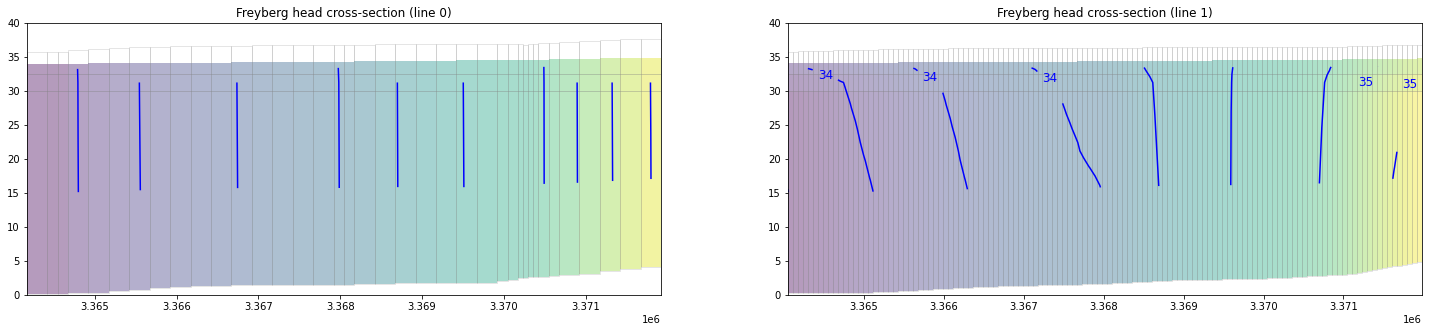

In [10]:
fig = plt.figure(figsize=(25, 5))

for i, line in enumerate(lines):
    ax = fig.add_subplot(1, len(lines), i + 1)
    ax.set_title(f"Freyberg head cross-section (line {i})")
    xsect = flopy.plot.PlotCrossSection(modelgrid=mfgrid,
                                        ax=ax,
                                        line={'line': lines[i]},
                                        geographic_coords=True)
    xsect.plot_array(head, head=head, alpha=0.4)
    xsect.plot_ibound(ibound=ibound, head=head)
    xsect.plot_inactive(ibound=ibound)
    contours = xsect.contour_array(head,
                                   masked_values=[999.0],
                                   head=head,
                                   levels=levels,
                                   alpha=1.0,
                                   colors='blue')
    plt.clabel(contours,
               fmt='%.0f',
               colors='blue',
               fontsize=12)
    xsect.plot_grid(alpha=0.2)
    ax.set_ylim([0,40])  # set y axis range to ignore low elevations

The `head` argument can be a 1D array or a 2D array matching the shape of the grid (i.e., `head.shape == (layer count, ncpl)`).

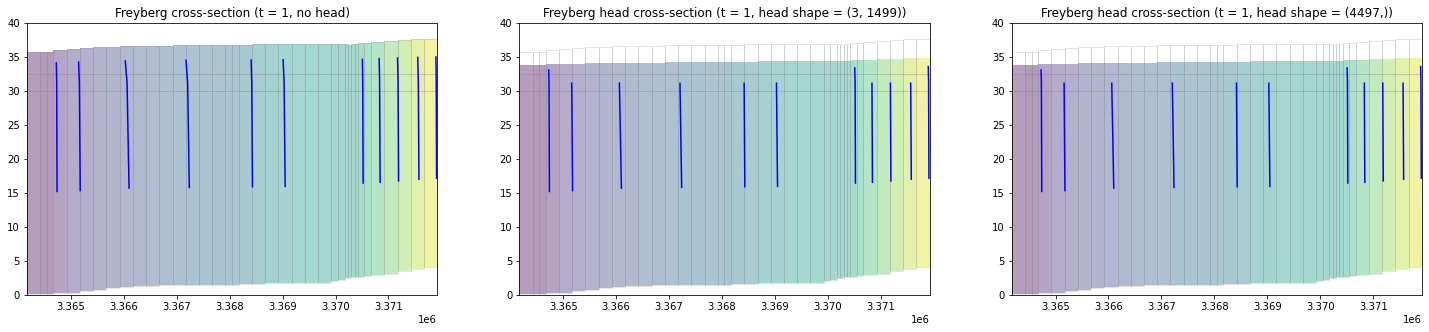

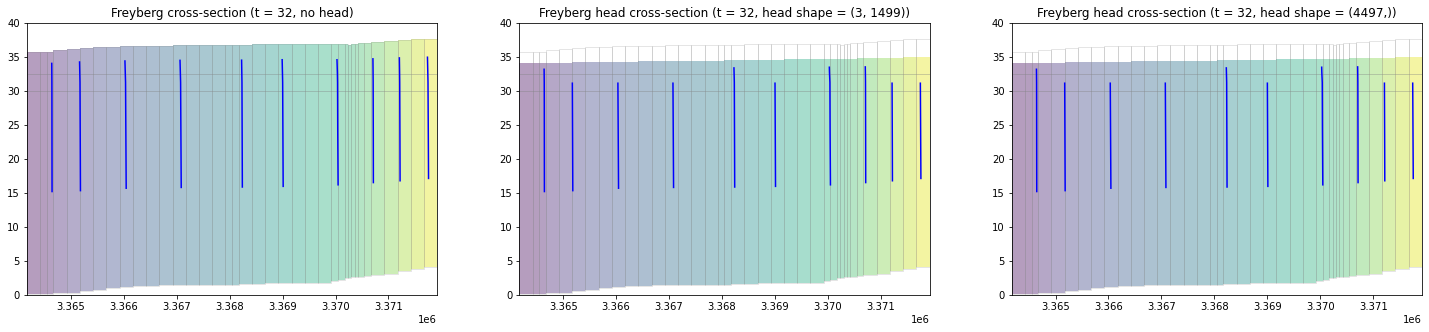

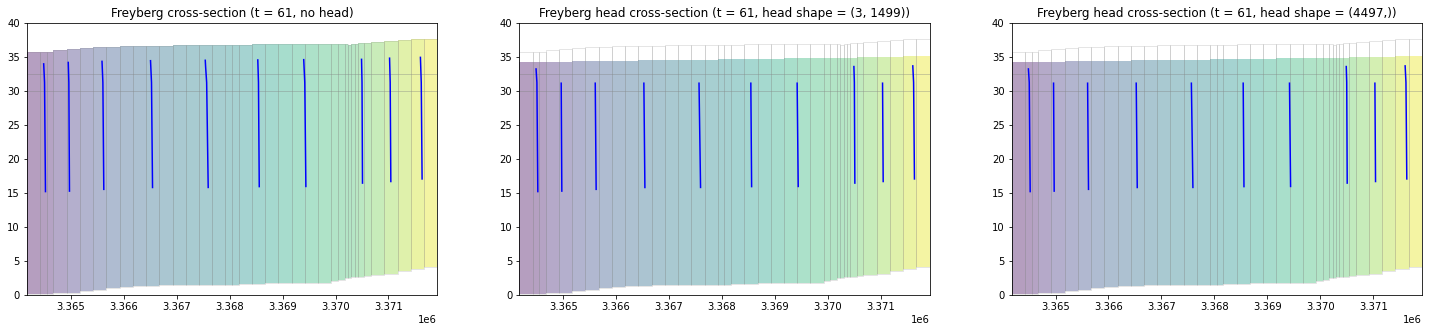

In [11]:
line = lines[0]

for time in times[0:3]:
    head = np.array(hds.get_data(totim=time))
    head2 = np.hstack(head)

    fig = plt.figure(figsize=(25, 5))
    ax = fig.add_subplot(1, 3, 1)
    ax.set_title(f"Freyberg cross-section (t = {int(time)}, no head)")
    xsect = flopy.plot.PlotCrossSection(modelgrid=mfgrid,
                                        ax=ax,
                                        line={'line': line},
                                        geographic_coords=True)
    cmap = xsect.plot_array(head2,
                            masked_values=[-999.99],
                            alpha=0.4,)
    contours = xsect.contour_array(head2,
                                   levels=levels,
                                   alpha=1.0,
                                   colors='blue')
    xsect.plot_inactive(ibound=ibound, color_noflow =(0.8,0.8,0.8))
    xsect.plot_grid(alpha=0.2)
    ax.set_ylim([0,40])  # set y axis range to ignore low elevations

    ax = fig.add_subplot(1, 3, 2)
    ax.set_title(f"Freyberg head cross-section (t = {int(time)}, head shape = {head.shape})")
    xsect = flopy.plot.PlotCrossSection(modelgrid=mfgrid,
                                        ax=ax,
                                        line={'line': line},
                                        geographic_coords=True)
    cmap = xsect.plot_array(head,
                            masked_values=[-999.99],
                            head=head,
                            alpha=0.4,)
    contours = xsect.contour_array(head,
                                   head=head,
                                   levels=levels,
                                   alpha=1.0,
                                   colors='blue')
    xsect.plot_inactive(ibound=ibound, color_noflow =(0.8,0.8,0.8))
    xsect.plot_grid(alpha=0.2)
    ax.set_ylim([0,40])

    ax = fig.add_subplot(1, 3, 3)
    ax.set_title(f"Freyberg head cross-section (t = {int(time)}, head shape = {head2.shape})")
    xsect = flopy.plot.PlotCrossSection(modelgrid=mfgrid,
                                        ax=ax,
                                        line={'line': line},
                                        geographic_coords=True)
    cmap = xsect.plot_array(head2,
                            masked_values=[-999.99],
                            head=head2,
                            alpha=0.4,)
    contours = xsect.contour_array(head2,
                                   head=head2,
                                   levels=levels,
                                   alpha=1.0,
                                   colors='blue')
    xsect.plot_inactive(ibound=ibound, color_noflow =(0.8,0.8,0.8))
    xsect.plot_grid(alpha=0.2)
    ax.set_ylim([0,40])

In [12]:
try:
    # ignore PermissionError on Windows
    temp_dir.cleanup()
except:
    pass